In [83]:
import pandas as pd
import datetime as dt
import numpy as np
import tqdm

In [58]:
import pycaret

In [59]:
data = pd.read_csv("ts_raw.csv")

In [60]:
data['Date'] = pd.to_datetime(data['Date'])

In [61]:
data.head()

,Date,Function A,Function B,Function C
0,2020-01-01,715,188,987
1,2020-02-01,153,180,653
2,2020-03-01,128,994,215
3,2020-04-01,910,175,323
4,2020-05-01,210,336,277


In [62]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        33 non-null     datetime64[ns]
 1   Function A  33 non-null     int64         
 2   Function B  33 non-null     int64         
 3   Function C  33 non-null     int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 1.2 KB


<AxesSubplot:xlabel='Date'>

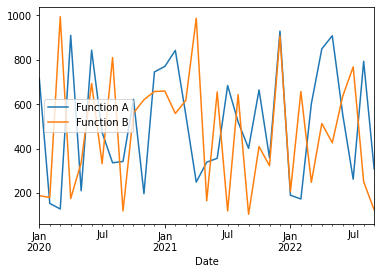

In [63]:
# plot the data
data.plot(y=['Function A','Function B'],x='Date')

In [90]:
# List of Functions
all_functions = list((data.columns))
all_functions.remove('Date')
all_functions

['Function A', 'Function B', 'Function C']

In [91]:
all_functions

['Function A', 'Function B', 'Function C']

In [93]:
all_functions = ['Function A', 'Function B', 'Function C']

In [106]:
all_functions_df = []
#for i in tqdm(data['time_series'].head(10000).unique()):
for i in all_functions:
    #l = load_model('trained_models/' + str(i), verbose=False)
    #p = predict_model(l, data=score_df)
    #df = get_crypto_data(i, "2021-01-01", "2022-05-31")
    df = data[['Date']]
    df['function'] = i
    df['volume'] = data[i]
    all_functions_df.append(df)

In [107]:
all_functions_df

[         Date    function  volume
 0  2020-01-01  Function A     715
 1  2020-02-01  Function A     153
 2  2020-03-01  Function A     128
 3  2020-04-01  Function A     910
 4  2020-05-01  Function A     210
 5  2020-06-01  Function A     843
 6  2020-07-01  Function A     473
 7  2020-08-01  Function A     336
 8  2020-09-01  Function A     342
 9  2020-10-01  Function A     622
 10 2020-11-01  Function A     197
 11 2020-12-01  Function A     745
 12 2021-01-01  Function A     770
 13 2021-02-01  Function A     842
 14 2021-03-01  Function A     552
 15 2021-04-01  Function A     249
 16 2021-05-01  Function A     339
 17 2021-06-01  Function A     356
 18 2021-07-01  Function A     684
 19 2021-08-01  Function A     520
 20 2021-09-01  Function A     401
 21 2021-10-01  Function A     664
 22 2021-11-01  Function A     358
 23 2021-12-01  Function A     929
 24 2022-01-01  Function A     190
 25 2022-02-01  Function A     173
 26 2022-03-01  Function A     602
 27 2022-04-01  Func

In [113]:
concat_functions_df = pd.concat(all_functions_df, axis=0)
#concat_functions_df =concat_functions_df.rename(columns={'dt': 'date'})
concat_functions_df.head()

,Date,function,volume
0,2020-01-01,Function A,715
1,2020-02-01,Function A,153
2,2020-03-01,Function A,128
3,2020-04-01,Function A,910
4,2020-05-01,Function A,210


In [114]:
all_data = concat_functions_df.copy()

# extract features from date
all_data['month'] = [i.month for i in all_data['Date']]
all_data['year'] = [i.year for i in all_data['Date']]
all_data['quarter'] = [i.quarter for i in all_data['Date']]

In [115]:
all_data

,Date,function,volume,month,year,quarter
0,2020-01-01,Function A,715,1,2020,1
1,2020-02-01,Function A,153,2,2020,1
2,2020-03-01,Function A,128,3,2020,1
3,2020-04-01,Function A,910,4,2020,2
4,2020-05-01,Function A,210,5,2020,2
...,...,...,...,...,...,...
28,2022-05-01,Function C,190,5,2022,2
29,2022-06-01,Function C,441,6,2022,2
30,2022-07-01,Function C,422,7,2022,3
31,2022-08-01,Function C,653,8,2022,3


In [118]:
# check the unique time_series
all_data['function'].nunique()

3

In [119]:
import os
os.getcwd()

'C:\\Users\\John Laurence\\Documents\\Data Science Projects\\Experiments\\Time Series'

In [123]:
all_ts = all_data['function'].unique()
all_ts

array(['Function A', 'Function B', 'Function C'], dtype=object)

In [126]:
from tqdm import tqdm
from pycaret.regression import *

#all_ts = data['symbol'].head(n=10000).unique()
#all_ts = data['time_series'].unique()
all_ts = all_data['function'].unique()

all_results = []
final_model = {}

for i in tqdm(all_ts):
    
    df_subset = all_data[all_data['function'] == i]
    i=i.replace("/", "_")
    # initialize setup from pycaret.regression
    s = setup(df_subset, target = 'volume', train_size = 0.95,
              data_split_shuffle = False, fold_strategy = 'timeseries', fold = 3,
              ignore_features = ['Date', 'function'],
              numeric_features = ['year'],
              categorical_features = ['quarter','month'],n_jobs=-6,
              silent = True, verbose = False, session_id = 123)
    
    # compare all models and select best one based on MAE
    best_model = compare_models(exclude=['dummy','par'],sort = 'MAE', verbose=False)
    
    # capture the compare result grid and store best model in list
    p = pull().iloc[0:1]
    p['function'] = str(i)
    all_results.append(p)
    
    # finalize model i.e. fit on entire data including test set
    f = finalize_model(best_model)
    
    # attach final model to a dictionary
    final_model[i] = f
    
    # save transformation pipeline and model as pickle file 
    save_model(f, model_name='trained_models/' + str(i), verbose=False)

100%|██████████| 3/3 [00:18<00:00,  6.16s/it]


In [128]:
final_model

{'Function A': LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-6, num_leaves=31, objective=None,
               random_state=123, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
 'Function B': ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
            max_iter=1000, normalize=False, positive=False, precompute=False,
            random_state=123, selection='cyclic', tol=0.0001, warm_start=False),
 'Function C': BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, alpha_init=None,
               compute_score=False, copy_X=True, fit_intercept=True,
               lambda_1=1e-06, lambda_2=1e-06, lambda_init=None, n_iter=300,
               normalize=False, tol=0.001, verbose=False)}

In [129]:
concat_results = pd.concat(all_results,axis=0)
concat_results.head()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec),function
lightgbm,Light Gradient Boosting Machine,219.5271,62374.3217,247.7669,-0.0508,0.5234,0.5604,0.0133,Function A
en,Elastic Net,222.4878,68135.2425,259.4001,-0.2940,0.6502,0.7584,0.0067,Function B
br,Bayesian Ridge,224.3305,68608.3593,261.5619,-0.2102,0.5995,0.6145,0.0067,Function C


### Notes
1. tqdm -> gives a % completion in the for loop iteration
2. silent = True in setup removes the prompt to confirm the pre-processed data setup
3. verbose=False avoids printing results on the console while training
4. n_jobs with negative value allocates that number as the count of cpu processors that will not be used in this process
5. pull() gives you the list of error metrics per model, getting the iloc[0:1] means you only get the top model and since you sorted using MAE, the model chosen is based on the lowest MAE
6. final_model = {} initializes a dictionary and can be a storage of all the finalized models

### Notes 2
You can store it in a list then use pd.concat(all_results,axis=0) to append

In [141]:
#Generate predictions using trained models

# create a date range from 2013 to 2019
all_dates = pd.date_range(start='2021-01-01', end = '2022-05-01', freq = 'MS')
# create empty dataframe
score_df = pd.DataFrame()
# add columns to dataset
score_df['Date'] = all_dates
score_df['month'] = [i.month for i in score_df['Date']]
score_df['year'] = [i.year for i in score_df['Date']]
score_df['quarter'] = [i.quarter for i in score_df['Date']]
# score_df['day_of_week'] = [i.dayofweek for i in score_df['date']]
# score_df['day_of_year'] = [i.dayofyear for i in score_df['date']]
score_df.head()

,Date,month,year,quarter
0,2021-01-01,1,2021,1
1,2021-02-01,2,2021,1
2,2021-03-01,3,2021,1
3,2021-04-01,4,2021,2
4,2021-05-01,5,2021,2


In [142]:
from pycaret.regression import load_model, predict_model
all_score_df = []
for i in tqdm(all_data['function'].unique()):
#for i in tqdm(data['time_series'].unique()):
    i = i.replace("/", "_")
    l = load_model('trained_models/' + str(i), verbose=False)
    p = predict_model(l, data=score_df)
    p['function'] = i.replace("_", "/")
    all_score_df.append(p)
concat_df = pd.concat(all_score_df, axis=0)
concat_df.head()

100%|██████████| 3/3 [00:00<00:00,  3.45it/s]


,Date,month,year,quarter,Label,function
0,2021-01-01,1,2021,1,514.454545,Function A
1,2021-02-01,2,2021,1,514.454545,Function A
2,2021-03-01,3,2021,1,514.454545,Function A
3,2021-04-01,4,2021,2,514.454545,Function A
4,2021-05-01,5,2021,2,514.454545,Function A


In [143]:
final_df = pd.merge(concat_df, all_data[['volume','Date','function']], how = 'left', left_on=['Date', 'function'], right_on = ['Date', 'function'])
final_df.tail()

,Date,month,year,quarter,Label,function,volume
46,2022-01-01,1,2022,1,524.452222,Function C,290
47,2022-02-01,2,2022,1,445.641584,Function C,273
48,2022-03-01,3,2022,1,430.634314,Function C,567
49,2022-04-01,4,2022,2,502.530269,Function C,838
50,2022-05-01,5,2022,2,438.726903,Function C,190


In [ ]:
#use TQDM HERE